# Table of Contents
* [0. Set-up](#Set-up)

* [1. Getting the Data](#1.-Getting-the-Data)
    * [1.1 Data Scraping](#1.1-Data-Scraping)
    * [1.2 Data Cleaning](#1.2-Data-Cleaning)
    
* [2. Clustering](#2.-Clustering)

# 0.  Set-up

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
%matplotlib inline
import sys, re, csv
from bs4 import BeautifulSoup
import urllib, time
from urllib.request import Request, urlopen, URLError, HTTPError
# from urlparse import urlparse
import _pickle as pickle
# from ParseDataByLeague import ParsePlyrDataById
#sys.path.insert(1,'/Users/zyzdiana/GitHub/AC299r/code')

# 1. Getting the Data

## 1.1 Data Scraping

In [5]:
# Get urls for every team roaster
request = Request("http://www.espn.com/nba/players")
response = urlopen(request)
the_page = response.read()
pool = BeautifulSoup(the_page, 'html.parser')
teams_a = pool.findAll('a')[:60]
team_urls = {}
for i in range(0,30):
    team = teams_a[i*2]['href'].split('/')
    team_urls[teams_a[i*2+1].contents[0]] = 'http://www.espn.com/nba/team/roster/_/name/%s/%s' % (team[-2],team[-1])
# pickle.dump(team_urls,open('pickled_files/team_urls.p','wb'))

In [6]:
players_by_team = {}
player_to_id = {}
id_to_player = {}
count = 0
for team, url in team_urls.items():
    # Get players for each team
    request = Request(url)
    response = urlopen(request)
    the_page = response.read()
    pool = BeautifulSoup(the_page, 'html.parser')

    players_by_team[team] = {}
    for a in pool.findAll('a', href=True):
        if 'http://www.espn.com/nba/player/_/id/' in a['href']:
            player_name = a.contents[0]
            player_id = a['href'].split('/')[-2]
            players_by_team[team][player_name] = player_id
            player_to_id[player_name] = player_id
            id_to_player[player_id] = player_name
            count += 1
print("Scraped %s players" % count)
# pickle.dump(players_by_team,open('pickled_files/players_by_team.p','wb'))
# pickle.dump(player_to_id,open('pickled_files/player_to_id.p','wb'))
# pickle.dump(id_to_player,open('pickled_files/id_to_player.p','wb'))

Scraped 496 players


In [30]:
team_urls = pickle.load(open('pickled_files/team_urls.p','rb'))
print(team_urls.keys())

players_by_team = pickle.load(open('pickled_files/players_by_team.p','rb'))
player_to_id = pickle.load(open('pickled_files/player_to_id.p','rb'))
id_to_player = pickle.load(open('pickled_files/id_to_player.p','rb'))

ModuleNotFoundError: No module named 'BeautifulSoup'

In [6]:
league = 'nba'
year = 2015
hasData = []
for team, players in players_by_team.iteritems():
    print "*********************************", team, "*********************************"
    for player, plyr_id in players.iteritems():
        hasData.append(ParsePlyrDataById(league,int(plyr_id),year))

********************************* Los Angeles Lakers *********************************
Parsing data:

	Player Name	: Tyler Ennis
	League		: NBA
	Team		: Los Angeles Lakers
	Year		: 2015
123
Success! 15
15
There were 87 games!
Parsing data:

	Player Name	: Lonzo Ball
	League		: NBA
	Team		: Los Angeles Lakers
	Year		: 2015
5
Only 5 Games available, skipping player.
Parsing data:

	Player Name	: Kentavious Caldwell-Pope
	League		: NBA
	Team		: Pope Game By Game Stats and Performance
	Year		: 2015
108
Success! 3
3
There were 85 games!
Parsing data:

	Player Name	: Brandon Ingram
	League		: NBA
	Team		: Los Angeles Lakers
	Year		: 2015
5
Only 5 Games available, skipping player.
Parsing data:

	Player Name	: Thomas Bryant
	League		: NBA
	Team		: Los Angeles Lakers
	Year		: 2015
2
Only 2 Games available, skipping player.
Parsing data:

	Player Name	: Andrew Bogut
	League		: NBA
	Team		: Los Angeles Lakers
	Year		: 2015
141
Success! 33
33
There were 88 games!
Parsing data:

	Player Name	: Jos

## 1.2 Data Cleaning

In [7]:
def clean_dir(ls):
    if '.DS_Store' in ls:
        ls.remove('.DS_Store')
        return ls
    else:
        return ls

In [8]:
file_ls = clean_dir(os.listdir('./data/'))
# df = pd.read_csv('data/%s' % file_ls[0])
df = pd.read_csv('data/NBA_Stephen_Curry_2016.csv')

In [9]:
df.head()

,ID,NumDate,StDate,Opp,Score,Res,FGA,FGM,FGP,3PA,...,FTM,FTP,PTS,REB,AST,BLK,STL,PF,TO,MIN
0,3975,20160413,Wed 4/13,MEM,125-104,W,24,15,0.625,19,...,6,1.0,46,4,6,0,2,2,2,30
1,3975,20160410,Sun 4/10,SA,92-86,W,22,13,0.591,9,...,7,1.0,37,5,5,0,2,4,4,35
2,3975,20160409,Sat 4/9,MEM,100-99,W,22,7,0.318,14,...,0,0.0,17,9,8,0,1,1,2,34
3,3975,20160407,Thu 4/7,SA,112-101,W,19,11,0.579,7,...,2,1.0,27,5,9,0,2,2,3,36
4,3975,20160405,Tue 4/5,MIN,117-124,L,25,7,0.280,14,...,3,1.0,21,6,15,0,3,4,3,43


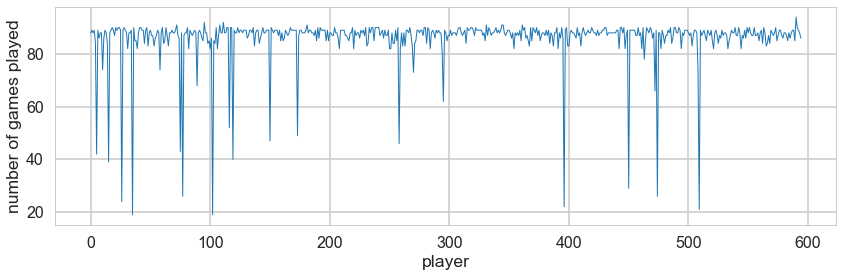

In [10]:
# Get the initial feature array
X_raw = []
for f in file_ls:
    df = pd.read_csv('data/%s' % f)
    xx = df[['ID','FGP','3PP','FTP','PTS','REB','AST','BLK','STL','PF','TO','MIN']].values
    if xx.shape[0] > 10:
        X_raw.append(xx)
        
num_games = [xx.shape[0] for xx in X_raw]

# For each player, take a look at how many games do we have data for
plt.figure(figsize = [14,4])
plt.plot(num_games, lw = 1)
plt.xlabel('player')
plt.ylabel('number of games played')
plt.show()

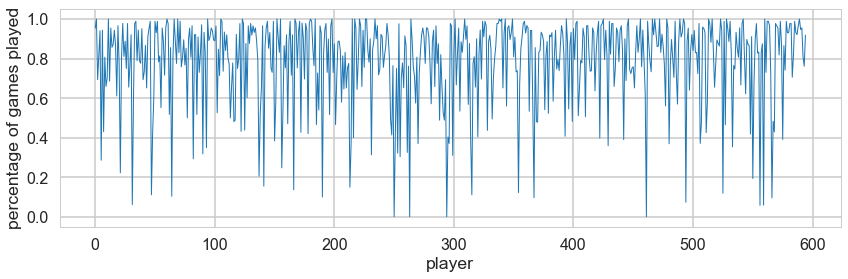

In [11]:
# We are only keeping data for players that have played more than 10% of the total number of games in a season
games_played = []
for xx in X_raw:
    games_played.append(np.sum(xx[:,-1] != 0)*1./xx.shape[0])
    
plt.figure(figsize = [14,4])
plt.plot(games_played, lw = 1)
plt.xlabel('player')
plt.ylabel('percentage of games played')
plt.show()

In [12]:
# We are only keeping data for players that have played more than 10% of the total number of games in a season
idx_ls = np.where(np.array(games_played) < 0.1)[0]
for i in reversed(idx_ls):
    X_raw.pop(i)

In [13]:
features = ['ID','NUM_GM','FGP','3PP','FTP','PTS','REB','AST','BLK','STL','PF','TO','MIN']
X = np.empty([len(X_raw), len(features)])
for idx, xx in enumerate(X_raw):
    X[idx,0] = xx[0,0]
    X[idx,1] = xx.shape[0]
    X[idx,2:] = np.average(xx[:,1:], axis = 0)

In [22]:
# create a few dictionaries to convert between the name of the statistics to idx in feature array
feature_to_idx = {}
idx_to_feature = {}
for idx, feature in enumerate(features[1:]):
    feature_to_idx[feature] = idx
    idx_to_feature[idx] = feature

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(np.array(X[:,1:]))
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

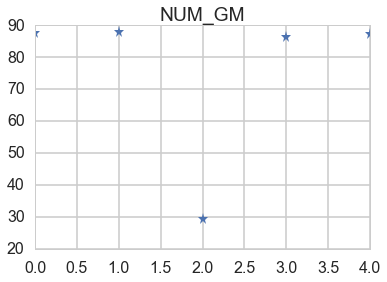

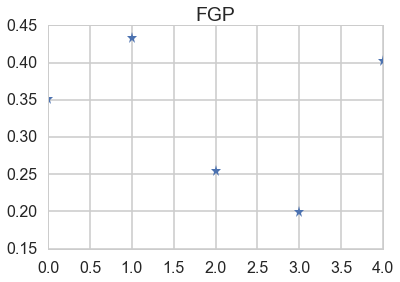

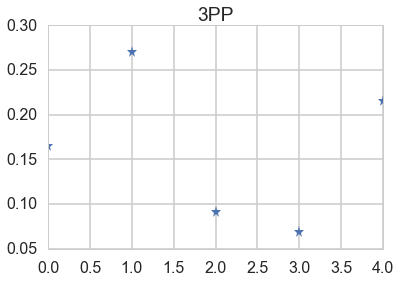

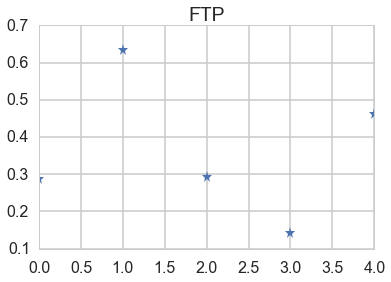

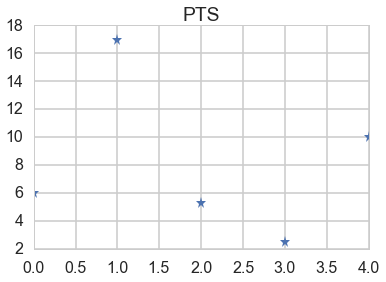

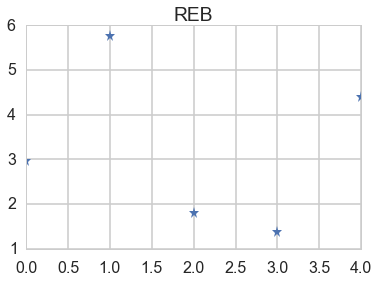

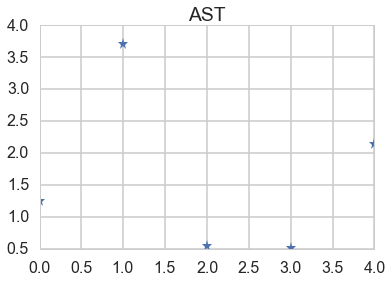

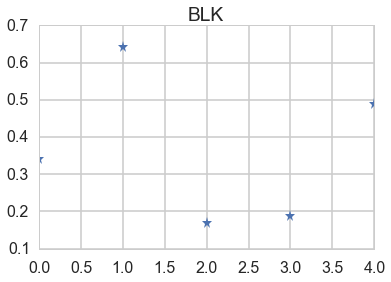

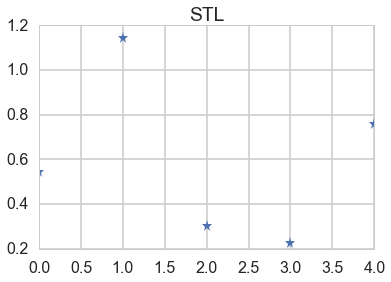

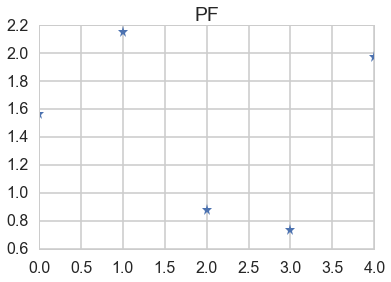

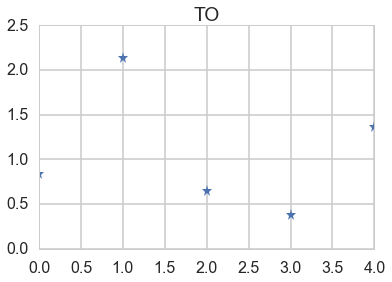

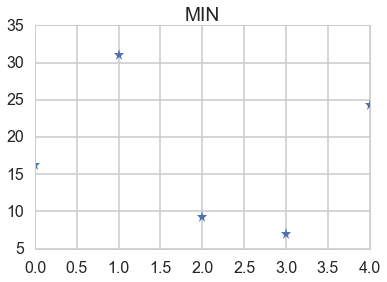

In [30]:
for i in xrange(cluster_centers.shape[1]):
    plt.plot(cluster_centers[:,i], '*')
    plt.title(features[i+1])
    plt.show()

In [54]:
df_stats = pd.DataFrame(data = X[:,1:], columns = features[1:])
df_stats.head()

,NUM_GM,FGP,3PP,FTP,PTS,REB,AST,BLK,STL,PF,TO,MIN
0,90.0,0.318578,0.257644,0.253344,6.366667,1.322222,2.233333,0.122222,0.411111,1.666667,1.077778,14.066667
1,84.0,0.422512,0.222190,0.415750,8.702381,6.130952,1.535714,0.666667,0.738095,1.880952,0.821429,22.523810
2,88.0,0.199875,0.053034,0.088068,1.704545,1.420455,0.340909,0.147727,0.193182,1.068182,0.465909,6.352273
3,86.0,0.409733,0.334337,0.482116,10.197674,6.011628,1.662791,0.662791,0.860465,2.093023,1.511628,28.302326
4,89.0,0.510652,0.327449,0.452438,14.887640,7.191011,3.134831,1.438202,0.820225,1.943820,1.314607,31.292135


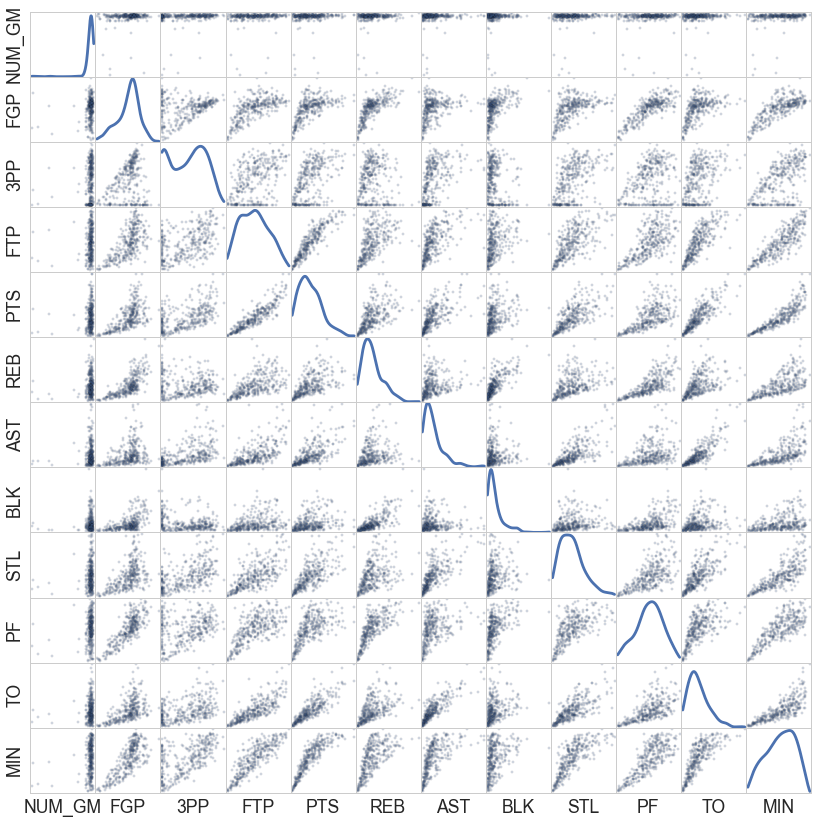

In [32]:
axs = pd.tools.plotting.scatter_matrix(df_stats, alpha=0.2, figsize=(14, 14), diagonal='kde'); #the diagonal will show kernel density
[ax.set_yticks([]) for ax in axs[:,0]] #turn off the ticks that take up way too much space in such a crammed figure
[ax.set_xticks([]) for ax in axs[-1,:]];

## HMM on player shooting data

In [162]:
from EM import RunEM, BayesianEM

In [17]:
file_ls = clean_dir(os.listdir('./data/'))
df = pd.read_csv('data/NBA_Stephen_Curry_2016.csv')
df.head()

,ID,NumDate,StDate,Opp,Score,Res,FGA,FGM,FGP,3PA,...,FTM,FTP,PTS,REB,AST,BLK,STL,PF,TO,MIN
0,3975,20160413,Wed 4/13,MEM,125-104,W,24,15,0.625,19,...,6,1.0,46,4,6,0,2,2,2,30
1,3975,20160410,Sun 4/10,SA,92-86,W,22,13,0.591,9,...,7,1.0,37,5,5,0,2,4,4,35
2,3975,20160409,Sat 4/9,MEM,100-99,W,22,7,0.318,14,...,0,0.0,17,9,8,0,1,1,2,34
3,3975,20160407,Thu 4/7,SA,112-101,W,19,11,0.579,7,...,2,1.0,27,5,9,0,2,2,3,36
4,3975,20160405,Tue 4/5,MIN,117-124,L,25,7,0.280,14,...,3,1.0,21,6,15,0,3,4,3,43


In [176]:
def Run_HMM(player_id = None, year = 2016, runBayesian = False, player = None):
    if player is None:
        player = id_to_player[player_id]
    df = pd.read_csv('data/NBA_%s_%s.csv' % (('_').join(player.split(' ')), year))
    Y_FG = df.FGM.values.reshape([1,-1])
    Y_3P = df['3PM'].values.reshape([1,-1])
    Y_FT = df.FTM.values.reshape([1,-1])
    p_FG, pp_FG, pll_FG, pul_FG, sigma2e_FG, x_post_FG, sigma2_post = RunEM(Y_FG, binomialN = df.FGA.values)
    p_3P, pp_3P, pll_3P, pul_3P, sigma2e_3P, x_post_3P, sigma2_post = RunEM(Y_3P, binomialN = df['3PA'].values)
    p_FT, pp_FT, pll_FT, pul_FT, sigma2e_FT, x_post_FT, sigma2_post = RunEM(Y_FT, binomialN = df.FTA.values)

    if runBayesian:
        gibbs_x_FG, sigmas_FG, flag_FG = BayesianEM(3000, 300, sigma2e_FG, Y_FG[0,:], binomialN = df.FGA.values, x_0 = x_post_FG, thin=0, max_iter = 15)
        gibbs_x_3P, sigmas_3P, flag_3P = BayesianEM(3000, 300, sigma2e_3P, Y_3P[0,:], binomialN = df['3PA'].values, x_0 = x_post_3P, thin=0, max_iter = 15)
        gibbs_x_FT, sigmas_FT, flag_FT = BayesianEM(3000, 300, sigma2e_FT, Y_FT[0,:], binomialN = df.FTA.values, x_0 = x_post_FT, thin=0, max_iter = 15)
        pickle.dump(gibbs_x_FG,open('BEM_%s_%s_FG.p' % (('_').join(player.split(' ')), year),'wb'))
        pickle.dump(gibbs_x_3P,open('BEM_%s_%s_3P.p' % (('_').join(player.split(' ')), year),'wb'))
        pickle.dump(gibbs_x_FT,open('BEM_%s_%s_FT.p' % (('_').join(player.split(' ')), year),'wb'))
        
    if player is None:
        player = id_to_player[str(df['ID'][0])]
    plt.figure(figsize = (14,5))
    plt.subplot(1, 3, 1)
    plt.plot(pll_FG[1:], 'g--')
    plt.plot(pul_FG[1:],'g--')
    plt.plot(p_FG[1:], 'g')
    plt.title('Field Goal, %s' % player)
    plt.xlabel('Game Index')
    plt.ylabel('Performance')
    plt.subplot(1, 3, 2)
    plt.plot(pll_3P[1:], 'g--')
    plt.plot(pul_3P[1:],'g--')
    plt.plot(p_3P[1:], 'g')
    plt.title('Three Point, %s' % player)
    plt.xlabel('Game Index')
    plt.ylabel('Performance')
    plt.subplot(1, 3, 3)
    plt.plot(pll_FT[1:], 'g--')
    plt.plot(pul_FT[1:],'g--')
    plt.plot(p_FT[1:], 'g')
    plt.title('Free Throw, %s' % player)
    plt.xlabel('Game Index')
    plt.ylabel('Performance')
    plt.tight_layout()
    plt.savefig('Result_%s_%s.pdf' % (('_').join(player.split(' ')), year))
    plt.show()

initial sigma2e is 0.25

Converged after 128 iterations
sigma2e is  0.000448823713301
runtime: 2.137022018432617 seconds
initial sigma2e is 0.25

Converged after 172 iterations
sigma2e is  0.00792931267758
runtime: 2.891188144683838 seconds
initial sigma2e is 0.25

Converged after 115 iterations
sigma2e is  0.0292960093174
runtime: 2.0914230346679688 seconds


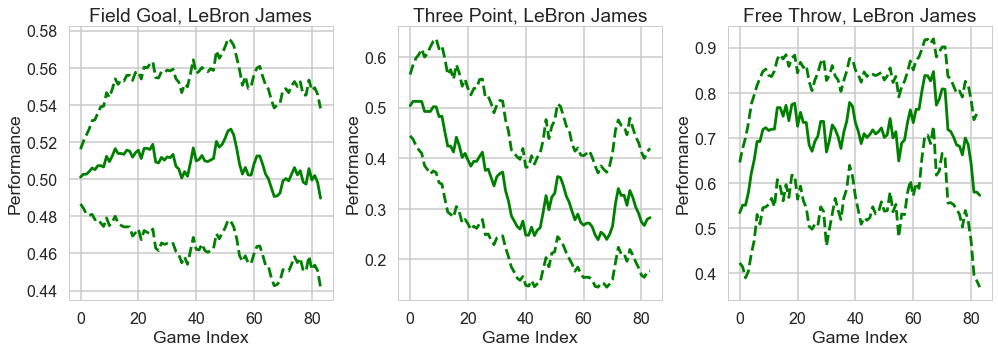

In [164]:
year = 2016
player = 'LeBron James'
player_id = player_to_id[player]
Run_HMM(player_id,  year, False)

initial sigma2e is 0.25

Converged after 104 iterations
sigma2e is  0.000381309635199
runtime: 1.8557538986206055 seconds
initial sigma2e is 0.25

Converged after 134 iterations
sigma2e is  0.000619517720504
runtime: 2.2739551067352295 seconds
initial sigma2e is 0.25

Converged after 124 iterations
sigma2e is  0.135082790868
runtime: 2.4440200328826904 seconds


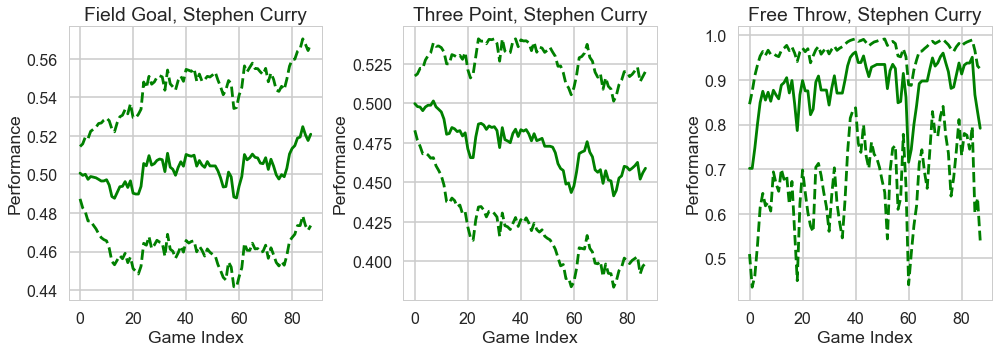

In [239]:
year = 2016
player = 'Stephen Curry'
player_id = player_to_id[player]
Run_HMM(player_id, year, False)

In [ ]:
pickle.load()

initial sigma2e is 0.25

Converged after 90 iterations
sigma2e is  0.000374712947974
runtime: 1.7116408348083496 seconds
initial sigma2e is 0.25

Converged after 129 iterations
sigma2e is  0.00398927101737
runtime: 2.308204174041748 seconds
initial sigma2e is 0.25

Converged after 101 iterations
sigma2e is  0.0870620870918
runtime: 1.944173812866211 seconds


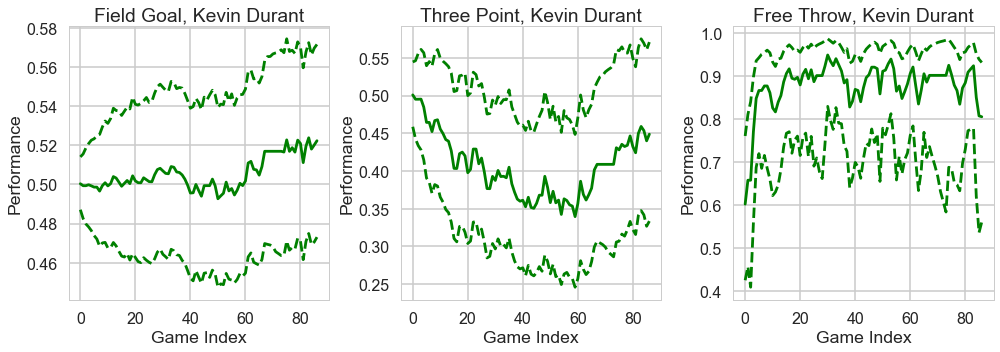

In [174]:
year = 2016
player = 'Kevin Durant'
player_id = player_to_id[player]
Run_HMM(player_id, year, False, player)

initial sigma2e is 0.25

Converged after 180 iterations
sigma2e is  0.000676282651649
runtime: 2.6456620693206787 seconds
initial sigma2e is 0.25

Converged after 235 iterations
sigma2e is  0.00178413812916
runtime: 3.081998109817505 seconds
initial sigma2e is 0.25

Converged after 212 iterations
sigma2e is  0.0225055367085
runtime: 2.6595120429992676 seconds


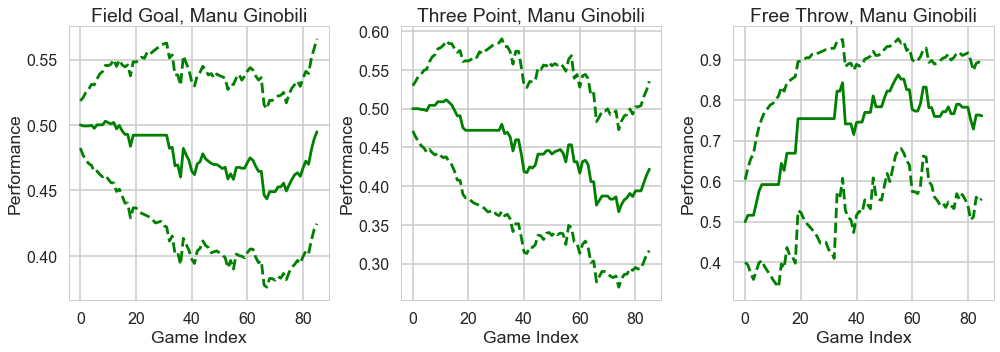

In [167]:
year = 2016
player = 'Manu Ginobili'
player_id = player_to_id[player]
Run_HMM(player_id, year, False)

initial sigma2e is 0.25

Converged after 128 iterations
sigma2e is  0.000418323828829
runtime: 2.233888864517212 seconds
initial sigma2e is 0.25

Converged after 423 iterations
sigma2e is  0.000888284440127
runtime: 4.356441020965576 seconds
initial sigma2e is 0.25

Converged after 176 iterations
sigma2e is  0.0405675664913
runtime: 3.0079879760742188 seconds


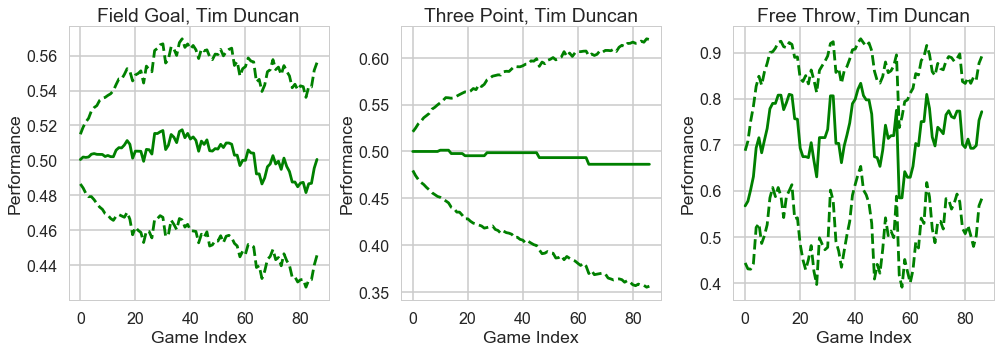

In [177]:
year = 2015
player = 'Tim Duncan'
player_id = 215
Run_HMM(player_id, year, False, player)

initial sigma2e is 0.25

Converged after 125 iterations
sigma2e is  0.000757054782878
runtime: 2.223119020462036 seconds
initial sigma2e is 0.25

Converged after 315 iterations
sigma2e is  0.0805501246009
runtime: 4.186340808868408 seconds
initial sigma2e is 0.25

Converged after 130 iterations
sigma2e is  0.0360525787366
runtime: 2.312577962875366 seconds


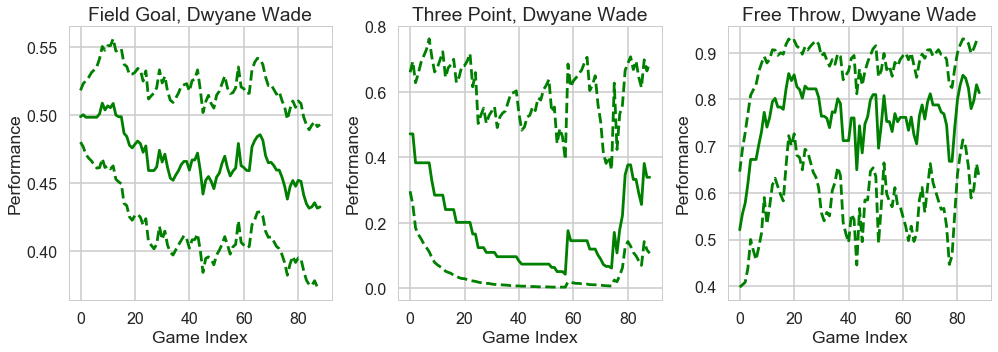

In [185]:
year = 2016
player = 'Dwyane Wade'
Run_HMM(player_id, year, False, player)

initial sigma2e is 0.25

Converged after 134 iterations
sigma2e is  0.000944441234428
runtime: 2.3671019077301025 seconds
initial sigma2e is 0.25

Converged after 238 iterations
sigma2e is  0.00728206333707
runtime: 3.304104804992676 seconds
initial sigma2e is 0.25

Converged after 165 iterations
sigma2e is  0.0266511675629
runtime: 2.3431291580200195 seconds


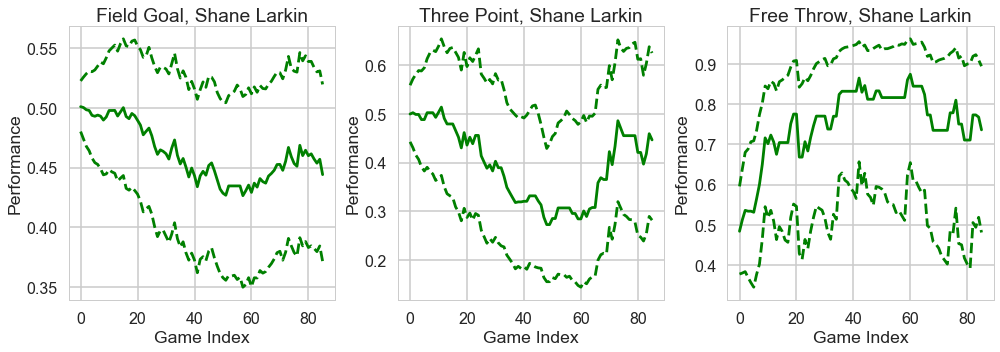

In [181]:
year = 2016
player = 'Shane Larkin'
Run_HMM(player_id, year, False, player)

initial sigma2e is 0.25

Converged after 137 iterations
sigma2e is  0.000818509312083
runtime: 2.3281519412994385 seconds
initial sigma2e is 0.25

Converged after 183 iterations
sigma2e is  0.0299633370642
runtime: 3.2559659481048584 seconds
initial sigma2e is 0.25

Converged after 79 iterations
sigma2e is  0.0577824455651
runtime: 1.5911259651184082 seconds


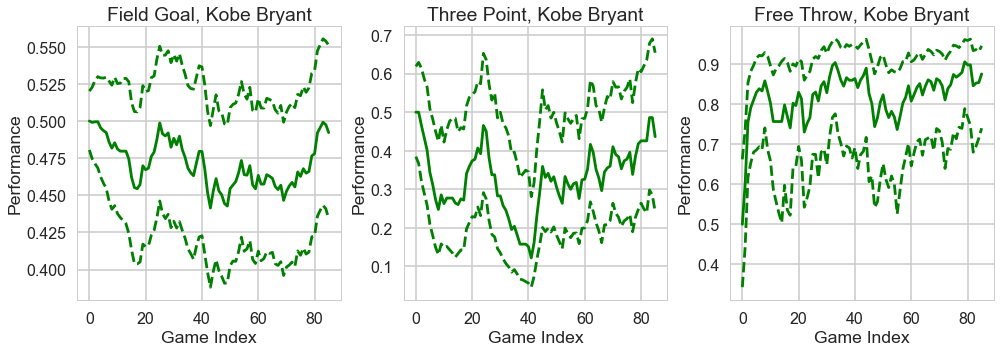

In [180]:
year = 2013
player = 'Kobe Bryant'
player_id = 110
Run_HMM(player_id, year, False, player)

In [225]:
player_data = []
binomialN = []
player = 'Manu Ginobili'
columnM = '3PM'
columnA = '3PA'
for year in range(2003, 2017):
    df = pd.read_csv('data/NBA_Manu_Ginobili_%s.csv' % year)
    player_data.append(df[columnM].values.sum())
    binomialN.append(df[columnA].values.sum())

In [226]:
player_data = []
binomialN = []
player = 'Kobe Bryant'
columnM = 'FGM'
columnA = 'FGA'
for year in range(1997, 2016):
    df = pd.read_csv('data/NBA_Kobe_Bryant_%s.csv' % year)
    player_data.append(df[columnM].values.sum())
    binomialN.append(df[columnA].values.sum())

In [222]:
player_data = []
binomialN = []
player = 'Tim Duncan'
columnM = '3PM'
columnA = '3PA'
for year in range(1998, 2015):
    df = pd.read_csv('data/NBA_Tim_Duncan_%s.csv' % year)
    player_data.append(df[columnM].values.sum())
    binomialN.append(df[columnA].values.sum())

In [228]:
p_FG, pp_FG, pll_FG, pul_FG, sigma2e_FG, x_post_FG, sigma2_post_FG = RunEM(np.array(player_data).reshape([1,-1]), binomialN = binomialN)

initial sigma2e is 0.25

Converged after 16 iterations
sigma2e is  0.00550253959652
runtime: 0.30287885665893555 seconds


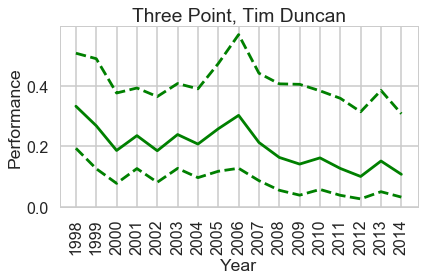

In [224]:
xx = range(1998,2015)
plt.plot(xx, pll_FG, 'g--')
plt.plot(xx, pul_FG,'g--')
plt.plot(xx, p_FG, 'g')
plt.xticks(xx,rotation='vertical')
plt.title('Three Point, %s' % player)
plt.xlabel('Year')
plt.ylabel('Performance')
plt.tight_layout()
plt.savefig('/Users/zyzdiana/Desktop/%s_3P.pdf'%player)
plt.show()

In [229]:
gibbs_x_FG, sigmas_FG, flag_FG = BayesianEM(3000, 300, sigma2e_FG, np.array(player_data), np.array(binomialN), x_0 = x_post_FG, thin=0, max_iter = 2)

0 0 1000 2000 3000 1 0 1000 2000 3000 2 0 1000 2000 3000 Did not converge in 2 iterations
sigma2e is  57.9731562857


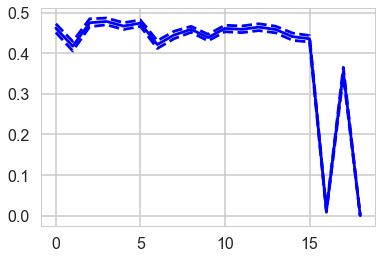

In [230]:
p = np.exp(gibbs_x_FG[:,1:])/(1+np.exp(gibbs_x_FG[:,1:]))
plt.plot(np.mean(p, axis=0),'b')
plt.plot(np.percentile(p, 25, axis=0),'b--')
plt.plot(np.percentile(p, 75, axis=0),'b--')

In [60]:
year = 2016
player = 'Stephen Curry'
df = pd.read_csv('data/NBA_Stephen_Curry_2016.csv')
Y_FG = df.FGM.values
Y_3P = df['3PM'].values
Y_FT = df.FTM.values
p_FG, pp_FG, pll_FG, pul_FG, sigma2e_FG, x_post_FG, sigma2_post_FG = RunEM(Y_FG.reshape([1,-1]), binomialN = df.FGA.values)
p_3P, pp_3P, pll_3P, pul_3P, sigma2e_3P, x_post_3P, sigma2_post_3P = RunEM(Y_3P.reshape([1,-1]), binomialN = df['3PA'].values)
p_FT, pp_FT, pll_FT, pul_FT, sigma2e_FT, x_post_FT, sigma2_post_FT = RunEM(Y_FT.reshape([1,-1]), binomialN = df.FTA.values)

initial sigma2e is 0.25

Converged after 104 iterations
sigma2e is  0.000381309635199
runtime: 1.967315912246704 seconds
initial sigma2e is 0.25

Converged after 134 iterations
sigma2e is  0.000619517720504
runtime: 2.7757568359375 seconds
initial sigma2e is 0.25

Converged after 124 iterations
sigma2e is  0.135082790868
runtime: 2.5850720405578613 seconds


In [63]:
gibbs_x_FG, sigmas_FG, flag_FG = BayesianEM(3000, 300, sigma2e_FG, Y_FG, binomialN = df.FGA.values, x_0 = x_post_FG, thin=0, max_iter = 15)
pickle.dump(gibbs_x_FG,open('BEM_%s_%s_FG.p' % (('_').join(player.split(' ')), year),'wb'))

0 0 1000 2000 3000 1 0 1000 2000 3000 2 0 1000 2000 3000 3 0 1000 2000 3000 4 0 1000 2000 3000 5 0 1000 2000 3000 6 0 1000 2000 3000 7 0 1000 2000 3000 8 0 1000 2000 3000 9 0 1000 2000 3000 10 0 1000 2000 3000 11 0 1000 2000 3000 12 0 1000 2000 3000 13 0 1000 2000 3000 14 0 1000 2000 3000 15 0 1000 2000 3000 Did not converge in 15 iterations
sigma2e is  0.00026057313973


In [67]:
gibbs_x_3P, sigmas_3P, flag_3P = BayesianEM(3000, 300, sigma2e_3P, Y_3P, binomialN = df['3PA'].values, x_0 = x_post_3P, thin=0, max_iter = 15)
pickle.dump(gibbs_x_3P,open('BEM_%s_%s_3P.p' % (('_').join(player.split(' ')), year),'wb'))

0 0 1000 2000 3000 1 0 1000 2000 3000 2 0 1000 2000 3000 3 0 1000 2000 3000 4 0 1000 2000 3000 5 0 1000 2000 3000 6 0 1000 2000 3000 7 0 1000 2000 3000 8 0 1000 2000 3000 9 0 1000 2000 3000 10 0 1000 2000 3000 11 0 1000 2000 3000 12 0 1000 2000 3000 13 0 1000 2000 3000 14 0 1000 2000 3000 15 0 1000 2000 3000 Did not converge in 15 iterations
sigma2e is  0.000496840751538


In [110]:
gibbs_x_FT, sigmas_FT, flag_FT = BayesianEM(3000, 300, sigma2e_FT, Y_FT, binomialN = df.FTA.values, x_0 = x_post_FT, thin=0, max_iter = 5)
pickle.dump(gibbs_x_FT,open('BEM_%s_%s_FT.p' % (('_').join(player.split(' ')), year),'wb'))

0 0 1000 2000 3000 1 0 1000 2000 3000 2 0 1000 2000 3000 3 0 1000 2000 3000 4 0 1000 2000 3000 5 0 1000 2000 3000 Did not converge in 5 iterations
sigma2e is  0.919816797582


<function matplotlib.pyplot.scatter>

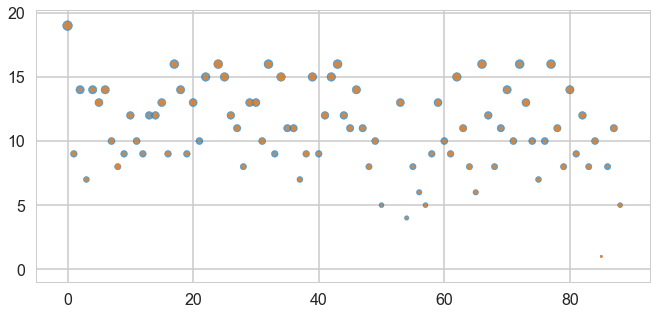

In [101]:
plt.figure(figsize = [11,5])
plt.scatter(range(len(df['3PA'].values)), df['3PA'].values, s = df['3PA'].values*5, alpha = 0.7)
plt.scatter(range(len(Y_3P)), df['3PA'].values, s = Y_3P*5, alpha = 0.7)
plt.scatter

<function matplotlib.pyplot.scatter>

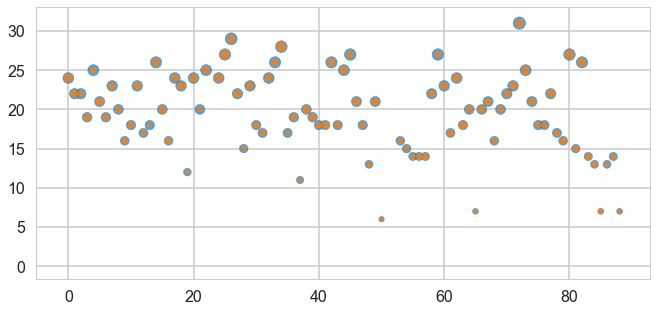

In [102]:
plt.figure(figsize = [11,5])
plt.scatter(range(len(df.FGA.values)), df.FGA.values, s = df.FGA.values*5, alpha = 0.7)
plt.scatter(range(len(Y_FG)), df.FGA.values, s = Y_FG*5, alpha = 0.7)
plt.scatter

<function matplotlib.pyplot.scatter>

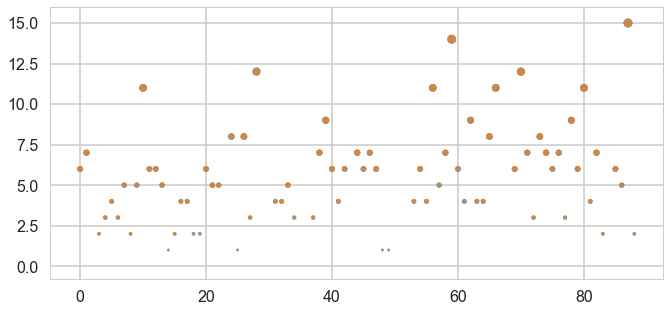

In [103]:
plt.figure(figsize = [11,5])
plt.scatter(range(len(df.FTA.values)), df.FTA.values, s = df.FTA.values*5, alpha = 0.7)
plt.scatter(range(len(Y_FT)), df.FTA.values, s = Y_FT*5, alpha = 0.7)
plt.scatter

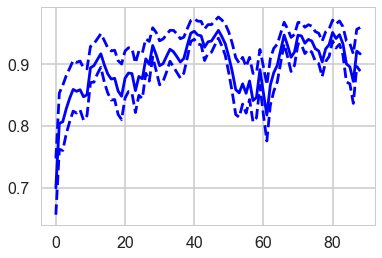

In [109]:
p = np.exp(gibbs_x_FT[:,1:])/(1+np.exp(gibbs_x_FT[:,1:]))
plt.plot(np.mean(p, axis=0),'b')
plt.plot(np.percentile(p, 25, axis=0),'b--')
plt.plot(np.percentile(p, 75, axis=0),'b--')

In [235]:
player = 'Stephen Curry'
year = 2016
gibbs_x_FG = pickle.load(open('BEM_%s_%s_FG.p' % (('_').join(player.split(' ')), year),'rb'))
gibbs_x_3P = pickle.load(open('BEM_%s_%s_3P.p' % (('_').join(player.split(' ')), year),'rb'))
gibbs_x_FT = pickle.load(open('BEM_%s_%s_FT.p' % (('_').join(player.split(' ')), year),'rb'))

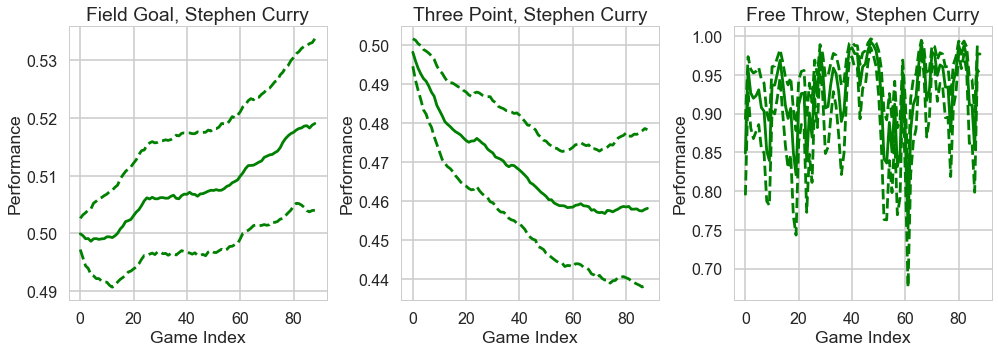

In [238]:
p_FG, pll_FG, pul_FG = np.percentile(np.exp(gibbs_x_FG[:,:])/(1+np.exp(gibbs_x_FG[:,:])), [50,25,75], axis=0)
p_3P, pll_3P, pul_3P = np.percentile(np.exp(gibbs_x_3P[:,:])/(1+np.exp(gibbs_x_3P[:,:])), [50,25,75], axis=0)
p_FT, pll_FT, pul_FT = np.percentile(np.exp(gibbs_x_FT[:,:])/(1+np.exp(gibbs_x_FT[:,:])), [50,25,75], axis=0)

plt.figure(figsize = (14,5))
plt.subplot(1, 3, 1)
plt.plot(pll_FG[1:], 'g--')
plt.plot(pul_FG[1:],'g--')
plt.plot(p_FG[1:], 'g')
plt.title('Field Goal, %s' % player)
plt.xlabel('Game Index')
plt.ylabel('Performance')
plt.subplot(1, 3, 2)
plt.plot(pll_3P[1:], 'g--')
plt.plot(pul_3P[1:],'g--')
plt.plot(p_3P[1:], 'g')
plt.title('Three Point, %s' % player)
plt.xlabel('Game Index')
plt.ylabel('Performance')
plt.subplot(1, 3, 3)
plt.plot(pll_FT[1:], 'g--')
plt.plot(pul_FT[1:],'g--')
plt.plot(p_FT[1:], 'g')
plt.title('Free Throw, %s' % player)
plt.xlabel('Game Index')
plt.ylabel('Performance')
plt.tight_layout()
plt.savefig('BEM_Result_%s_%s.pdf' % (('_').join(player.split(' ')), year))
plt.show()